# Advanced Lane Finding
The goals / steps of this project are the following:

1. Compute the **camera calibration** matrix and distortion coefficients given a set of chessboard images.
1. Apply a **distortion** correction to raw images.
1. Use color transforms, gradients, etc., to **create a thresholded binary image**.
1. Apply a perspective transform to rectify binary image (**"birds-eye view"**).
1. Detect lane pixels and fit to **find the lane boundary**.
1. Determine the **curvature** of the lane and vehicle position with respect to center.
1. **Warp** the detected lane boundaries back onto the original image.
1. **Output** visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration
First, I'll compute the camera calibration matrix and distortion coefficients using chessboard images.


In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# Read the list of calibration images
image_paths = glob.glob('camera_cal/calibration*.jpg') 

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in calibration image 

# object points
chessboard_x = 9
chessboard_y = 6
objp = np.zeros((chessboard_y*chessboard_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_x,0:chessboard_y].T.reshape(-1,2)

# Go through every image
for image_path in image_paths:
    img =  cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_x,chessboard_y),None)

    # Save corners to arrays
    if True == ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw corners
        img = cv2.drawChessboardCorners(img, (chessboard_x, chessboard_y), corners, ret)
        saved_image = image_path.replace('camera_cal', 'output_images/draw_camera_cal')
        plt.imsave(saved_image, img)
        #plt.imshow(img)
        #plt.savefig(saved_image)

# Calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



## 2. Distortion correction 



## 3. Create thresholded binary image
Use color transforms, gradients, etc., to create a thresholded binary image.

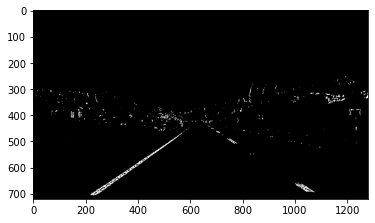

In [9]:
     ### Function of creating thresholded binary image
def threshold_binary(img, sobelx_thresh=(0, 255), channel_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Sobel Operator in x direction
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Apply threshold for sobel in x direction
    sobelx_binary = np.zeros_like(scaled_sobel)
    sobelx_binary[(scaled_sobel > sobelx_thresh[0]) & (scaled_sobel < sobelx_thresh[1])] = 1
    
    # Apply threshold for color channel (in s channel)
    channel_binary = np.zeros_like(s_channel)
    channel_binary[(s_channel > channel_thresh[0])&(s_channel < channel_thresh[1])] = 1

    # get new binary image by combining two binary image
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(sobelx_binary == 1) | (channel_binary == 1)] = 1

    return combined_binary


# Define the thresholds
sobelx_threshold = (70, 170)
channel_threshold = (170, 255)
# Go through every test image for undistortion and create thresholded binary image
test_image_paths = glob.glob('test_images/*.jpg') 
for test_image_path in test_image_paths:
    test_img = cv2.imread(test_image_path)

    # Distortion correction
    undist = cv2.undistort(test_img, mtx, dist, None, mtx)
    saved_undist_path = test_image_path.replace('test_images/', 'output_images/undist/undist_')
    #cv2.imwrite(saved_undist_path,undist)

    binary = threshold_binary(undist, sobelx_threshold, channel_threshold)
    plt.imshow(binary, cmap='Greys_r')

    # Save the combined binary image
    saved_binary_path = test_image_path.replace('test_images/', 'output_images/binary/binary_')
    cv2.imwrite(saved_binary_path,binary*255)




## 4. Birds-eye view
Apply the transform to every undisort image and save it to **birds_eye** folder.

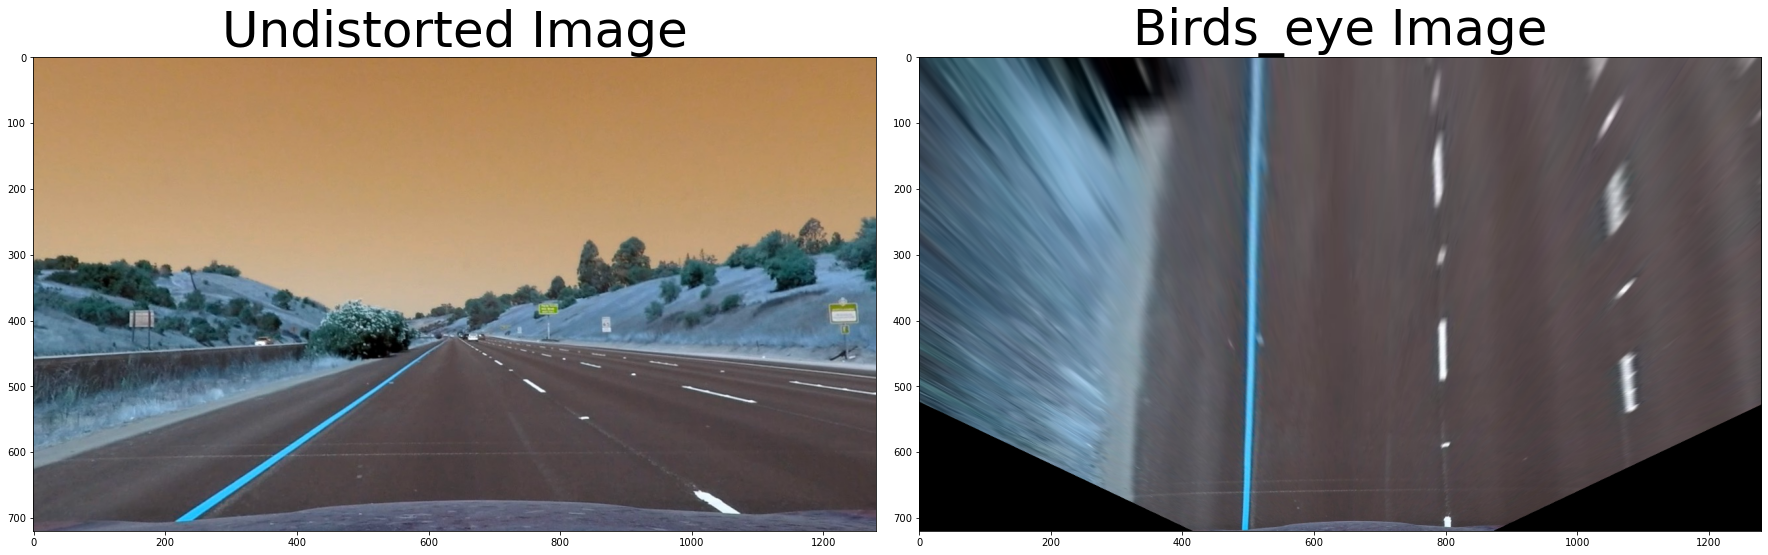

In [14]:
def transform_matrix():
    # Define 4 source points 
    test1_src = np.float32([[499, 530], [844, 530], [1008, 630], [362, 630]])
    straight2_src = np.float32([[557, 475], [729, 475], [961, 630], [345, 630]]) 
    src = straight2_src

    # Define 4 destination points 
    test1_dst = np.float32([[500, 550], [800, 550], [800, 630], [500, 630]])
    straight2_dst = np.float32([[500, 300], [800, 300], [800, 680], [500, 680]])

    dst = straight2_dst
    # Get the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Min = cv2.getPerspectiveTransform(dst, src)
    return M, Min
    
def transform(tran_matrix, img):
    ### Get the warped image,
    ### if tran_matrix = M, img = undist image => return birds_eye image
    ### if tran_matrix = Min, img = birds_eye image => return undist image
    
    return cv2.warpPerspective(img, tran_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)

undis_image_paths = glob.glob("output_images/undist/undist_*.jpg")

M, Min = transform_matrix()

# Go through all undistort image
for undis_image_path in undis_image_paths:
   
    undis_image = cv2.imread(undis_image_path)
    birds_eye_image = transform(M, undis_image)
    # Save the image
    birds_eye_image_path = undis_image_path.replace('undist', 'birds_eye')
    cv2.imwrite(birds_eye_image_path,birds_eye_image)
     


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undis_image)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(birds_eye_image)
ax2.set_title('Birds_eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Find the lane boundary
Detect lane pixels and fit to find the lane boundary.

In [20]:

from Finding_Lane import fit_polynomial

# Go through all warped image
birds_eye_image_paths = glob.glob("output_images/birds_eye/birds_eye_*.jpg")

for birds_eye_image_path in birds_eye_image_paths:
   
    birds_eye_image = cv2.imread(birds_eye_image_path)
    # Get the binary image for finding lane
    binary = threshold_binary(birds_eye_image, sobelx_thresh=(70, 170), channel_thresh=(170, 255))
    find_lane_path = birds_eye_image_path.replace('birds_eye', 'find_lane')
    find_lane_img = fit_polynomial(binary)[3]

    cv2.imwrite(find_lane_path,find_lane_img)

## 6. Lane curvature and vehicle position
Determine the curvature of the lane and vehicle position with respect to center.

In [23]:
from Measuring_Curvature import measure_curvature_real

def display_curvature(img, ym_pix, xm_pix): # Write and display the curvature to image
    ### img => birds eye image
    ### ym_pix => y distance in meter per pix
    ### xm_pix => x distance in meter per pix
    
    # get the curvature and position
    measure_binary = threshold_binary(img, sobelx_thresh=(70, 170), channel_thresh=(170, 255))
    left, right, veh_pos = measure_curvature_real(measure_binary, ym_pix, xm_pix)
    
    return write_curvature(img, left, right, veh_pos)
    

def write_curvature(img, left, right, pos):
    ### left => left point curvature value
    ### right => right point curvature value
    ### position => vehicle position in the lane, if in left pos < 0, if in right pos > 0
    
    # write the curvature to image
    x_max = img.shape[1]
    y_max = img.shape[0]
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    LeftText = (100,100)
    RightText = (100,200)
    PosText = (100,300)
    left_curvature_text         = "Left curvature:" + str(round(left, 2)) +"m"
    right_curvature_text         = "Right curvature:" + str(round(right, 2)) +"m"
    veh_pos_text         = "Vehicle position:" + str(round(pos, 2)) +"m"

    cv2.putText(img,left_curvature_text, 
        LeftText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    cv2.putText(img,right_curvature_text, 
        RightText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.putText(img,veh_pos_text, 
        PosText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    return img
    
    # go through all image
birds_eye_image_paths = glob.glob("output_images/birds_eye/birds_eye_*.jpg")

ym_par_pix = 7/720
xm_par_pix= 3.7/300

for birds_eye_image_path in birds_eye_image_paths:   
    
    # read the image
    birds_eye_image = cv2.imread(birds_eye_image_path)

    # get the curvature image
    curvature_image = display_curvature(birds_eye_image, ym_par_pix, xm_par_pix)
    
    # write curvature display image
    curvature_path = birds_eye_image_path.replace("birds_eye", "curvature")
    cv2.imwrite(curvature_path,curvature_image)


## 7. Warp lane boundaries
Warp the detected lane boundaries back onto the original image.

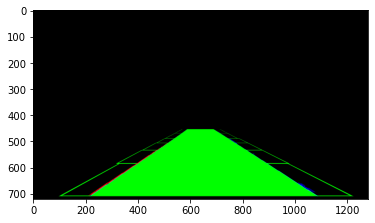

In [30]:
# Go through all images
def show_warp_lane(img, warp_lane):
    ### img => undistort image
    
    # Combine the result with the original image and return
    return cv2.addWeighted(img, 1, warp_lane, 0.3, 0)

def warp_lane(img): 
    ### img => birds eye image

    # get left_fitx, right_fitx, ploty
    binary_birds_eye = threshold_binary(img, sobelx_thresh=(70, 170), channel_thresh=(170, 255))
    #left_fitx¡d y points into usable format for cv2.fillPoly()
    left_fitx, right_fitx, ploty, color_warp = fit_polynomial(binary_birds_eye)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    return cv2.warpPerspective(color_warp, Min, (binary_birds_eye.shape[1], binary_birds_eye.shape[0])) 


for undis_image_path in undis_image_paths:   
      
    # Read image
    undis_image = cv2.imread(undis_image_path)
    birds_eye_image = transform(M, undis_image) 
    
    # get warped line image
    warped_lane = warp_lane(birds_eye_image)
    show_warped_lane = show_warp_lane(undis_image, warped_lane)
    
    # save image
    lane_image_path = undis_image_path.replace("undist", "warped_lane")
    cv2.imwrite(lane_image_path, show_warped_lane)
    plt.imshow(warped_lane)



## 8. Visual display
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


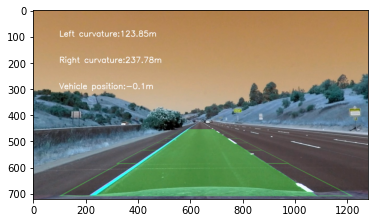

In [33]:
def visual_lane(img):
    birds_eye_image = transform(M, img) 
    
    # get warped line image
    warped_lane = warp_lane(birds_eye_image)
    show_warped_lane = show_warp_lane(img, warped_lane)
    
    # add curvature and position value
    measure_binary = threshold_binary(birds_eye_image, sobelx_thresh=(70, 170), channel_thresh=(170, 255))
    left, right, veh_pos = measure_curvature_real(measure_binary, ym_par_pix, xm_par_pix)
    
    return write_curvature(show_warped_lane, left, right, veh_pos)
    
for undis_image_path in undis_image_paths:   
    
    # Read image
    undis_image = cv2.imread(undis_image_path)         

    result_img = visual_lane(undis_image)
    
    # save image
    visual_lane_image_path = undis_image_path.replace("undist", "visual_lane")
    cv2.imwrite(visual_lane_image_path, result_img)
    plt.imshow(result_img)

## 9. Video

For the 

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_img(img):
    #undistort
    undis_img = cv2.undistort(img, mtx, dist, None, mtx)
    return visual_lane(undis_img)

video_output = 'test_videos_output/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")##.subclip(0,5)
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 4min 25s, sys: 39 s, total: 5min 4s
Wall time: 5min 54s


In [36]:
challenge_video_output = 'test_videos_output/challenge_video_output.mp4'

challenge_video_clip = VideoFileClip("challenge_video.mp4")##.subclip(0,5)
challenge_video_white_clip = challenge_video_clip.fl_image(process_img) #NOTE: this function expects color images!!
%time challenge_video_white_clip.write_videofile(challenge_video_output, audio=False)



/485 [01:10<01:46,  2.81it/s, now=None]
t:  49%|████▉     | 592/1199 [11:51<02:28,  4.08it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_video_output.mp4
CPU times: user 1min 24s, sys: 8.41 s, total: 1min 32s
Wall time: 2min 59s


In [37]:
harder_challenge_video_output = 'test_videos_output/harder_challenge_video_output.mp4'

harder_challenge_video_clip = VideoFileClip("harder_challenge_video.mp4")##.subclip(0,5)
harder_challenge_video_white_clip = harder_challenge_video_clip.fl_image(process_img) 
%time harder_challenge_video_white_clip.write_videofile(harder_challenge_video_output, audio=False)

:39<04:38,  3.25it/s, now=None]
t:  49%|████▉     | 592/1199 [03:39<06:06,  1.66it/s, now=None]

TypeError: expected non-empty vector for x